In [28]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from utils import config, utils

In [29]:
# Define the target and features
TARGET = "sentiment"
FEATURES = ["text", "title"]

## Data Preparation

In [30]:
data_raw = pd.read_csv("../res/input/cryptonews.csv")
df_tweets = data_raw.copy(deep=True)

data_raw.head()

,date,sentiment,source,subject,text,title,url
0,2023-04-05 06:52:09,"{'class': 'negative', 'polarity': -0.03, 'subj...",CoinTelegraph,defi,The compensation process is expected to start ...,Allbridge to first begin repaying stuck bridge...,https://cointelegraph.com/news/allbridge-to-fi...
1,2023-04-05 06:19:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoPotato,bitcoin,On-chain analytics revealed a sentiment shift ...,Bitcoin Hodl Patterns Indicate Cycle Shift to ...,https://cryptopotato.com/bitcoin-hodl-patterns...
2,2023-04-05 05:09:44,"{'class': 'negative', 'polarity': -0.04, 'subj...",CoinTelegraph,bitcoin,"Ether has broken the $1,900 resistance level f...",ETH hits 7-month high ahead of Shanghai and Ca...,https://cointelegraph.com/news/eth-hits-7-mont...
3,2023-04-05 01:09:52,"{'class': 'positive', 'polarity': 0.07, 'subje...",CoinTelegraph,bitcoin,"With a new quarterly production record, Marath...","Marathon Digital posts quarterly record of 2,1...",https://cointelegraph.com/news/marathon-digita...
4,2023-04-04 23:49:00,"{'class': 'positive', 'polarity': 0.4, 'subjec...",CryptoPotato,altcoin,The stablecoin BTG Dol will supposedly become ...,Brazilian Finance Giant BTG Pactual to Issue a...,https://cryptopotato.com/brazilian-finance-gia...


In [31]:
df_tweets.describe()

,date,sentiment,source,subject,text,title,url
count,18543,18543,18543,18543,18543,18543,18543
unique,18304,3196,3,6,18131,18511,18543
top,2022-01-14 00:00:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,bitcoin,"Get your daily, bite-sized digest of cryptoass...",Is it Too Late to Buy Shiba Inu? Crypto Expert...,https://cryptonews.com/news/celo-to-be-fastest...
freq,26,4195,8675,6439,326,4,1


In [32]:
df_tweets.isnull().sum()

date         0
sentiment    0
source       0
subject      0
text         0
title        0
url          0
dtype: int64

In [33]:
# Convert sentiment column from string to dict
df_tweets["sentiment"] = df_tweets["sentiment"].apply(eval)

# Split dictionary in separate columns
df_sentiment = pd.json_normalize(df_tweets["sentiment"])
df_tweets = pd.concat([df_tweets, df_sentiment], axis=1)

# Convert date column to datetime
df_tweets['date'] = pd.to_datetime(df_tweets['date'], format='mixed', errors='coerce')

df_tweets = df_tweets.drop(columns=["sentiment", "url"])
df_tweets = df_tweets.rename(columns={"class": "sentiment"})
df_tweets.head()

,date,source,subject,text,title,sentiment,polarity,subjectivity
0,2023-04-05 06:52:09,CoinTelegraph,defi,The compensation process is expected to start ...,Allbridge to first begin repaying stuck bridge...,negative,-0.03,0.20
1,2023-04-05 06:19:00,CryptoPotato,bitcoin,On-chain analytics revealed a sentiment shift ...,Bitcoin Hodl Patterns Indicate Cycle Shift to ...,neutral,0.00,0.00
2,2023-04-05 05:09:44,CoinTelegraph,bitcoin,"Ether has broken the $1,900 resistance level f...",ETH hits 7-month high ahead of Shanghai and Ca...,negative,-0.04,0.31
3,2023-04-05 01:09:52,CoinTelegraph,bitcoin,"With a new quarterly production record, Marath...","Marathon Digital posts quarterly record of 2,1...",positive,0.07,0.23
4,2023-04-04 23:49:00,CryptoPotato,altcoin,The stablecoin BTG Dol will supposedly become ...,Brazilian Finance Giant BTG Pactual to Issue a...,positive,0.40,0.40


## Model training

### Pretrained

#### Ollama
Due to poor performance and long execution times, this model will no longer be evaluated. The results can be found in the notebook located at `src/archive/llm-ollama.ipynb`

In [34]:
ollama_model = "llama3.1:latest"

In [35]:
# ollama_pipeline = utils.OllamaPipeline(
#     df=df_tweets,
#     features=FEATURES,
#     target=TARGET,
#     ollama_model=ollama_model,
#     model_name=ollama_model,
# )

In [36]:
# ollama_pipeline.evaluate()

#### Huggingface

In [37]:
from transformers import pipeline
import tqdm

pipe = pipeline("text-classification", model="finiteautomata/bertweet-base-sentiment-analysis")

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use cpu


In [38]:
display(df_tweets["title"], df_tweets["text"])

0        Allbridge to first begin repaying stuck bridge...
1        Bitcoin Hodl Patterns Indicate Cycle Shift to ...
2        ETH hits 7-month high ahead of Shanghai and Ca...
3        Marathon Digital posts quarterly record of 2,1...
4        Brazilian Finance Giant BTG Pactual to Issue a...
                               ...                        
18538    Cream Finance Suffers Another Exploit as Attac...
18539    French Central Bank's Blockchain Bond Trial Br...
18540    Facebook To Add 10,000 Jobs In EU For Metavers...
18541    Tech Crackdown Hasn't Halted Chinese Firms' Bl...
18542    Celo to Be Fastest EVM Chain by End of 2022, C...
Name: title, Length: 18543, dtype: object

0        The compensation process is expected to start ...
1        On-chain analytics revealed a sentiment shift ...
2        Ether has broken the $1,900 resistance level f...
3        With a new quarterly production record, Marath...
4        The stablecoin BTG Dol will supposedly become ...
                               ...                        
18538    Cream Finance (CREAM) suffered another flash l...
18539    Banque de France disclosed the results of its ...
18540    Advancing its project to become \x9caÂ\xa0meta...
18541    Chinese companies are still topping the blockc...
18542    Within a little more than a year, Celo aims to...
Name: text, Length: 18543, dtype: object

In [39]:
y_pred = []
its = len(df_tweets) // 15
df_tweets_shortened = df_tweets[:its]
for _, row in tqdm.tqdm(df_tweets_shortened.iterrows(), desc="Predicting sentiment"):
    result = pipe(
        {"text": row["title"], "text_pair": row["text"]},
        truncation=True  
    )
    y_pred.append(result)
df_tweets_shortened["y_pred"] = y_pred

Predicting sentiment: 10it [00:00, 21.40it/s]


In [40]:
df_tweets_shortened.head()

,date,source,subject,text,title,sentiment,polarity,subjectivity,y_pred
0,2023-04-05 06:52:09,CoinTelegraph,defi,The compensation process is expected to start ...,Allbridge to first begin repaying stuck bridge...,negative,-0.03,0.20,"{'label': 'NEU', 'score': 0.941013753414154}"
1,2023-04-05 06:19:00,CryptoPotato,bitcoin,On-chain analytics revealed a sentiment shift ...,Bitcoin Hodl Patterns Indicate Cycle Shift to ...,neutral,0.00,0.00,"{'label': 'NEU', 'score': 0.9213043451309204}"
2,2023-04-05 05:09:44,CoinTelegraph,bitcoin,"Ether has broken the $1,900 resistance level f...",ETH hits 7-month high ahead of Shanghai and Ca...,negative,-0.04,0.31,"{'label': 'POS', 'score': 0.6088979244232178}"
3,2023-04-05 01:09:52,CoinTelegraph,bitcoin,"With a new quarterly production record, Marath...","Marathon Digital posts quarterly record of 2,1...",positive,0.07,0.23,"{'label': 'POS', 'score': 0.7493367195129395}"
4,2023-04-04 23:49:00,CryptoPotato,altcoin,The stablecoin BTG Dol will supposedly become ...,Brazilian Finance Giant BTG Pactual to Issue a...,positive,0.40,0.40,"{'label': 'NEU', 'score': 0.9239023327827454}"


In [41]:
df_tweets_shortened["pred_sentiment"] = df_tweets_shortened["y_pred"].apply(lambda x: x["label"])
df_tweets_shortened["pred_sentiment"] = df_tweets_shortened["pred_sentiment"].replace({"POS": "positive", "NEU": "neutral", "NEG": "negative"})
df_tweets_shortened.head()

,date,source,subject,text,title,sentiment,polarity,subjectivity,y_pred,pred_sentiment
0,2023-04-05 06:52:09,CoinTelegraph,defi,The compensation process is expected to start ...,Allbridge to first begin repaying stuck bridge...,negative,-0.03,0.20,"{'label': 'NEU', 'score': 0.941013753414154}",neutral
1,2023-04-05 06:19:00,CryptoPotato,bitcoin,On-chain analytics revealed a sentiment shift ...,Bitcoin Hodl Patterns Indicate Cycle Shift to ...,neutral,0.00,0.00,"{'label': 'NEU', 'score': 0.9213043451309204}",neutral
2,2023-04-05 05:09:44,CoinTelegraph,bitcoin,"Ether has broken the $1,900 resistance level f...",ETH hits 7-month high ahead of Shanghai and Ca...,negative,-0.04,0.31,"{'label': 'POS', 'score': 0.6088979244232178}",positive
3,2023-04-05 01:09:52,CoinTelegraph,bitcoin,"With a new quarterly production record, Marath...","Marathon Digital posts quarterly record of 2,1...",positive,0.07,0.23,"{'label': 'POS', 'score': 0.7493367195129395}",positive
4,2023-04-04 23:49:00,CryptoPotato,altcoin,The stablecoin BTG Dol will supposedly become ...,Brazilian Finance Giant BTG Pactual to Issue a...,positive,0.40,0.40,"{'label': 'NEU', 'score': 0.9239023327827454}",neutral


[[0.33333333 0.66666667 0.        ]
 [0.25       0.75       0.        ]
 [0.33333333 0.66666667 0.        ]]


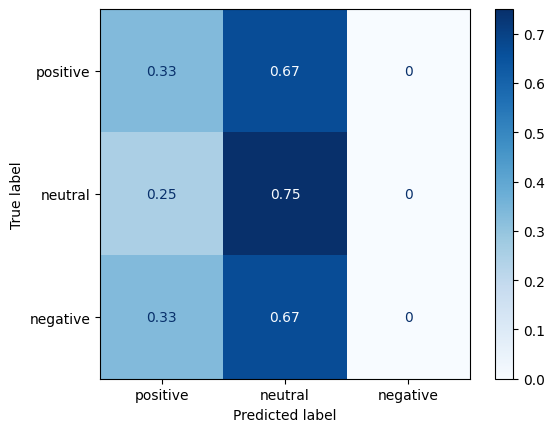

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(df_tweets_shortened["sentiment"], df_tweets_shortened["pred_sentiment"], labels=config.SENTIMENTS, normalize="true")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=config.SENTIMENTS)
disp.plot(cmap=plt.cm.Blues)

### Supervised

#### NLTK-Randomforest

In [43]:
nltk_rf_model = utils.CustomPipeline(
    df_tweets,
    FEATURES,
    TARGET, 
    steps=[
        ("preprocessor", ColumnTransformer(
             transformers=[
                (f'nltk_{feature}', Pipeline([
                ('compound_splitter', utils.CompoundWordSplitter()),
                ('tokenizer', utils.NLTKTokenizer()),
                ('tfidf', TfidfVectorizer())
            ]), feature) for feature in FEATURES]
        )),
        ("classifier", RandomForestClassifier(random_state=config.RANDOM_STATE))
    ],
    model_name="nltk_rf"
)

In [44]:
nltk_rf_model.fit(False)
nltk_rf_model.fit(True)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s


Classification Report for nltk_rf_unbalanced model_unbalanced test data:
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00         0
     neutral       1.00      1.00      1.00         1
    negative       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.33      0.33      0.33         2
weighted avg       0.50      0.50      0.50         2

Confusion Matrix for nltk_rf_unbalanced model_unbalanced test data:
[[0. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metri

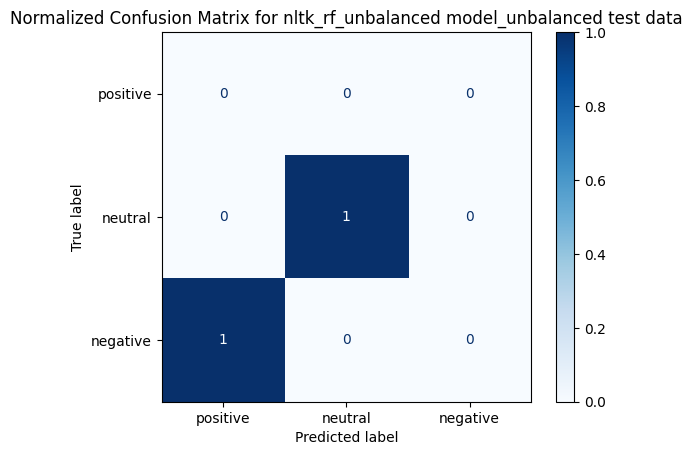

Classification Report for nltk_rf_balanced model_balanced test data:
              precision    recall  f1-score   support

    positive       1.00      0.50      0.67         2
     neutral       0.50      1.00      0.67         1
    negative       0.00      0.00      0.00         0

    accuracy                           0.67         3
   macro avg       0.50      0.50      0.44         3
weighted avg       0.83      0.67      0.67         3

Confusion Matrix for nltk_rf_balanced model_balanced test data:
[[0.5 0.5 0. ]
 [0.  1.  0. ]
 [0.  0.  0. ]]


d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklear

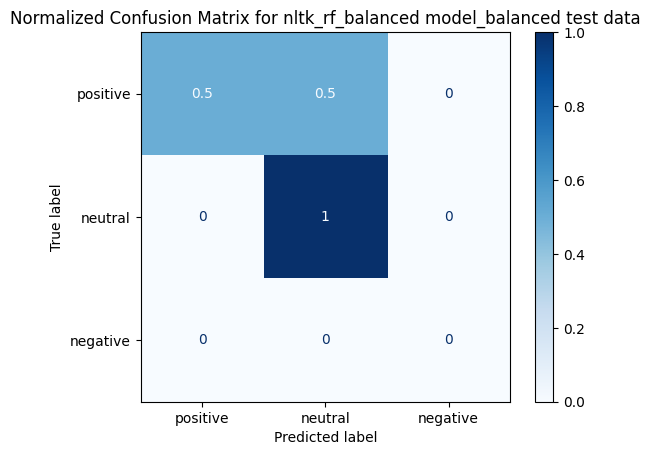

Classification Report for nltk_rf_balanced model_unbalanced test data:
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00         0
     neutral       1.00      1.00      1.00         1
    negative       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       0.67      0.67      0.67         2
weighted avg       1.00      1.00      1.00         2

Confusion Matrix for nltk_rf_balanced model_unbalanced test data:
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklear

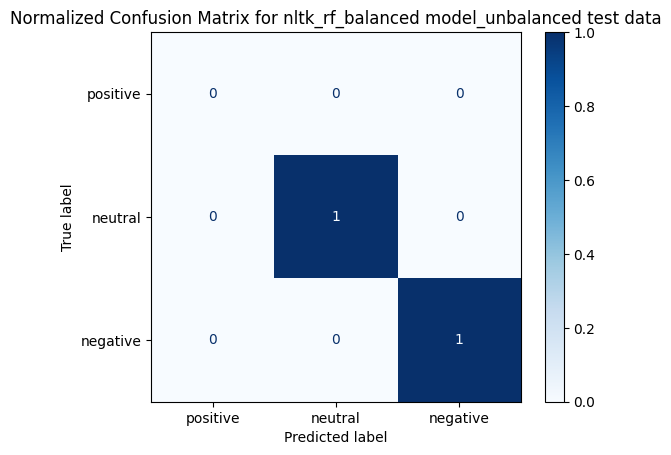

In [45]:
nltk_rf_model.evaluate(False, False)
nltk_rf_model.evaluate(True, True)
nltk_rf_model.evaluate(True, False)

In [46]:
nltk_rf_model.dump("../res/models")

#### NLTK-NGrams-RandomForest

In [47]:
nltk_rf_ngram_1_3_model = utils.CustomPipeline(
    df_tweets,
    FEATURES,
    TARGET, 
    steps=[
        ("preprocessor", ColumnTransformer(
             transformers=[
                (f'nltk_{feature}', Pipeline([
                ('compound_splitter', utils.CompoundWordSplitter()),
                ('tokenizer', utils.NLTKTokenizer()),
                ('tfidf', (TfidfVectorizer(ngram_range=(1, 3)))),
            ]), feature) for feature in FEATURES]
        )),
        ("classifier", RandomForestClassifier(random_state=config.RANDOM_STATE))
    ],
    model_name="nltk_rf_n_gram_1_3"
)

In [48]:
nltk_rf_ngram_1_3_model.fit(True)
nltk_rf_ngram_1_3_model.fit(False)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s


Classification Report for nltk_rf_n_gram_1_3_unbalanced model_unbalanced test data:
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00         0
     neutral       0.50      1.00      0.67         1
    negative       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.17      0.33      0.22         2
weighted avg       0.25      0.50      0.33         2

Confusion Matrix for nltk_rf_n_gram_1_3_unbalanced model_unbalanced test data:
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklear

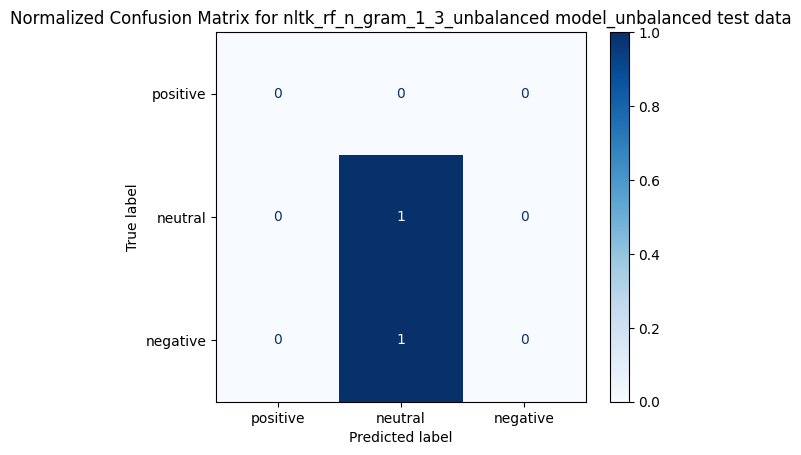

Classification Report for nltk_rf_n_gram_1_3_balanced model_balanced test data:
              precision    recall  f1-score   support

    positive       1.00      0.50      0.67         2
     neutral       0.50      1.00      0.67         1
    negative       0.00      0.00      0.00         0

    accuracy                           0.67         3
   macro avg       0.50      0.50      0.44         3
weighted avg       0.83      0.67      0.67         3

Confusion Matrix for nltk_rf_n_gram_1_3_balanced model_balanced test data:
[[0.5 0.5 0. ]
 [0.  1.  0. ]
 [0.  0.  0. ]]


d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklear

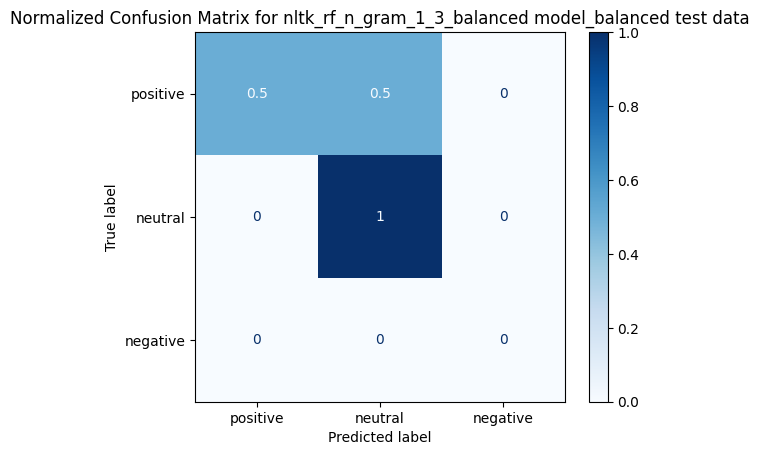

Classification Report for nltk_rf_n_gram_1_3_balanced model_unbalanced test data:
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00         0
     neutral       1.00      1.00      1.00         1
    negative       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       0.67      0.67      0.67         2
weighted avg       1.00      1.00      1.00         2

Confusion Matrix for nltk_rf_n_gram_1_3_balanced model_unbalanced test data:
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\NLP-CrowdFlow\.venv\Lib\site-packages\sklear

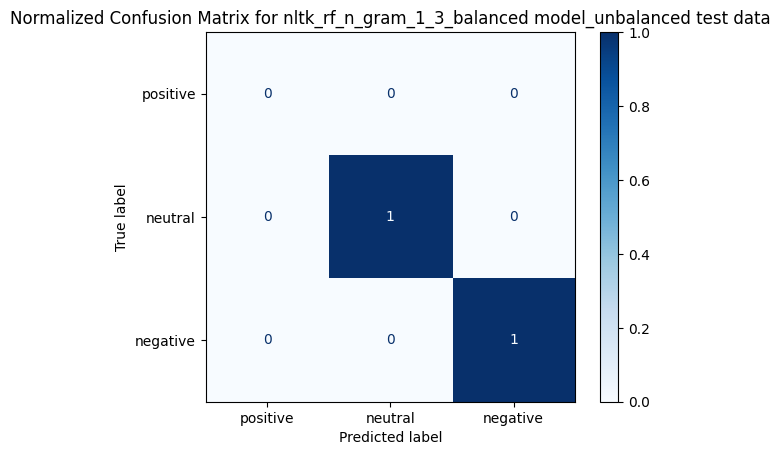

In [49]:
nltk_rf_ngram_1_3_model.evaluate(False, False)
nltk_rf_ngram_1_3_model.evaluate(True, True)
nltk_rf_ngram_1_3_model.evaluate(True, False)

In [50]:
# nltk_rf_ngram_1_3_model.dump("../res/models")